In [1]:
import tensorflow as tf
import keras
from PIL import Image
import glob, os
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


### Data Exploration
Udacity provided dataset

In [2]:
path = 'C:/Users/AVIK/Documents/Udacity Self Driving Cars/CarND-Behavioral-Cloning-P3-master/examples/data/'

df_log = pd.read_csv(path+"driving_log.csv")

print("Number of examples {}".format(len(df_log)))

df_log.head()

Number of examples 8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### Recovery Data-set added for vehicle movement after the bridge where right pavement is missing

In [4]:
df_log = pd.read_csv(path+"driving_log.csv")
names = [name for name in df_log.columns]
    
df_log_recovery = pd.read_csv(path+"driving_log_recovery.csv")
names_recovery = [name for name in df_log_recovery.columns]
df_log_recovery.rename(columns={names_recovery[0]:names[0], names_recovery[1]:names[1], names_recovery[2]:names[2],
                                names_recovery[3]:names[3],names_recovery[4]:names[4],names_recovery[5]:names[5],
                                names_recovery[6]:names[6]}, inplace=True)
print(len(df_log_recovery))

269


### Combined dataframe

In [5]:
df_log = df_log.append(df_log_recovery)
print(len(df_log))

8305


### Histogram of the steering column
Indicating that this is a imbalanced dataset where many dataset has close to 0 steering angle. Thus balancing the dataset for steering angles within +/- 0.2 deg is required.

(array([  1.20000000e+01,   7.00000000e+00,   7.00000000e+00,
          6.00000000e+00,   1.60000000e+01,   8.60000000e+01,
          8.20000000e+01,   3.00000000e+02,   4.74000000e+02,
          8.46000000e+02,   5.29100000e+03,   7.81000000e+02,
          1.61000000e+02,   1.72000000e+02,   4.40000000e+01,
          1.20000000e+01,   5.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 20 Patch objects>)

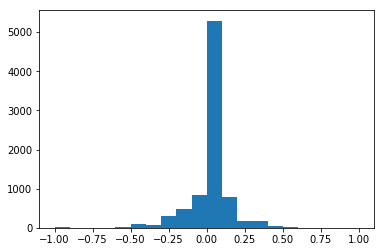

In [7]:
plt.hist(df_log["steering"],20)

### Analying central, left and right image

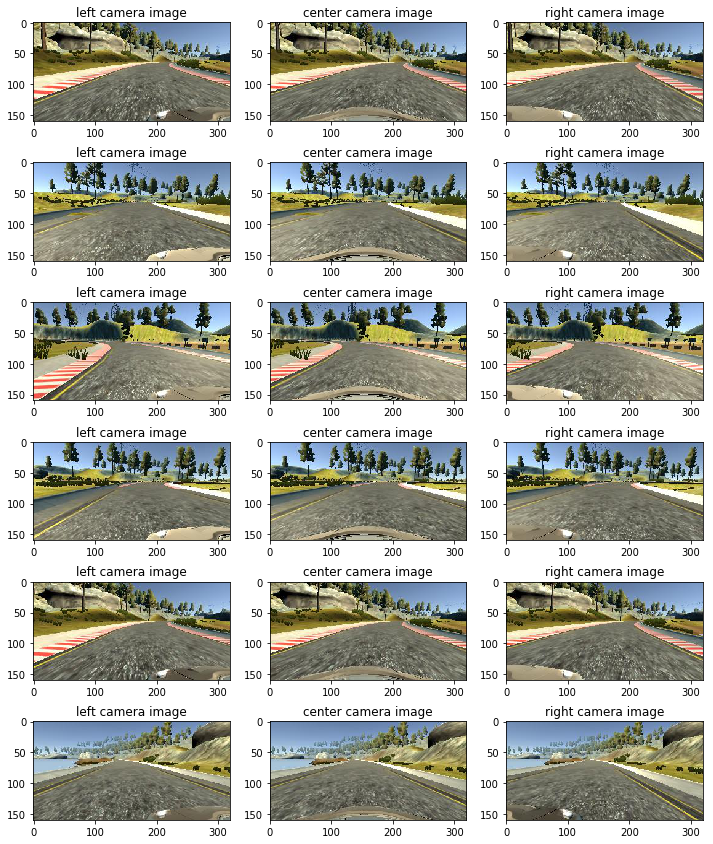

In [4]:
#infile = glob.glob(path+"IMG/*.jpg")

fig,ax = plt.subplots(6,3, figsize= (12,15))
ax = ax.ravel()
example_images = []
example_images_idx = []
for kk in range(6):
    rand_img_idx = np.random.randint(len(df_log))
    left_image_file = df_log['left'][rand_img_idx]
    center_image_file = df_log['center'][rand_img_idx] 
    right_image_file = df_log['right'][rand_img_idx]
    image = plt.imread(path+left_image_file[1:])
    image = np.asarray(image)
    ax[3*kk].imshow(image,cmap="gray")
    ax[3*kk].set_title("left camera image")
    image = plt.imread(path+center_image_file)
    image = np.asarray(image)
    ax[3*kk+1].imshow(image,cmap="gray")
    ax[3*kk+1].set_title("center camera image")
    example_images.append(image)
    example_images_idx.append(rand_img_idx)
    image = plt.imread(path+right_image_file[1:])
    image = np.asarray(image)
    ax[3*kk+2].imshow(image,cmap="gray")
    ax[3*kk+2].set_title("right camera image")


### Removing pixels along y-axis to limit the Region of Interst (ROI)

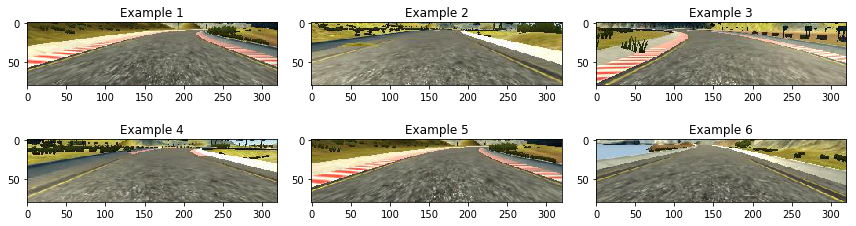

In [5]:
remove_top_pixels = 55
remove_bottom_pixels = 25
mod_example_images = []

fig, ax = plt.subplots(2,3,figsize=(12,5))
ax = ax.ravel()
for ii in range(6):
    cropped_images = example_images[ii]
    image_resized = cropped_images[remove_top_pixels:-remove_bottom_pixels,:,:]
    plt.subplot(3,3,ii+1)
    plt.imshow(image_resized, cmap="gray")
    plt.title("Example {}".format(ii+1))
    mod_example_images.append(image_resized)

plt.tight_layout()
plt.show()

### Spatial Binning - Resizing the image size for the neural net to train faster and avoid overfitting 

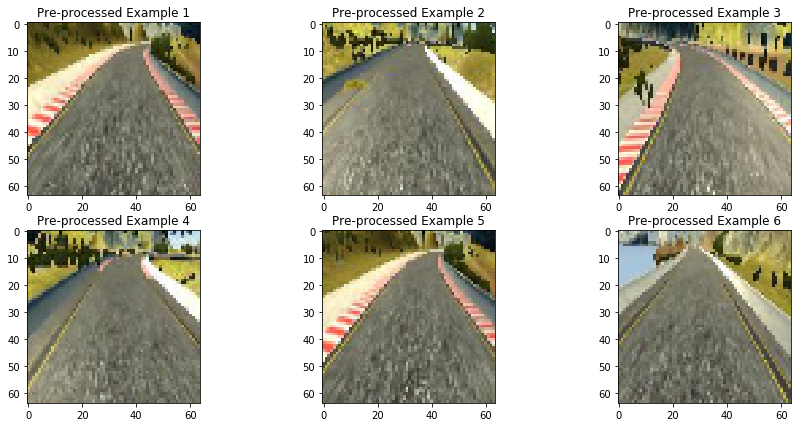

In [25]:
import cv2
WIDTH, HEIGHT = 64,64
fig,ax = plt.subplots(2,3,figsize=(15,7)) 
ax = ax.ravel()
for ii in range(6):
    image = cv2.resize(mod_example_images[ii],(WIDTH,HEIGHT))
    #image = (image-128)/256
    ax[ii].imshow(image,cmap="gray")
    ax[ii].set_title("Pre-processed Example {}".format(ii+1))

### Using the left and right camera image to augment image data

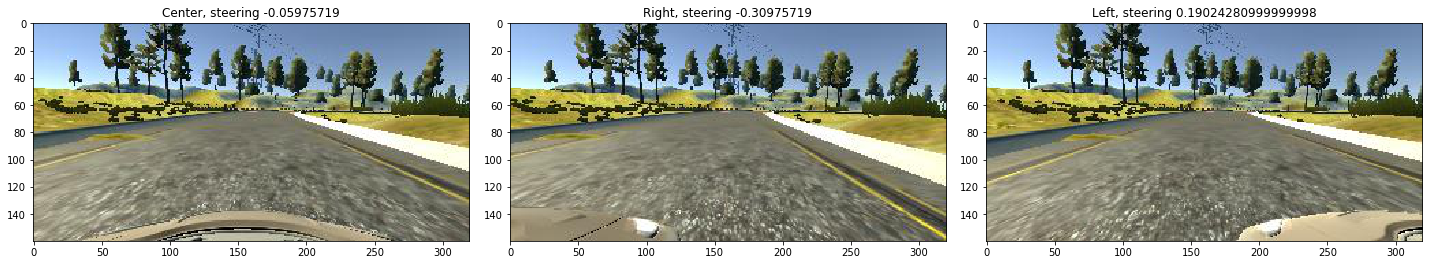

In [27]:
LEFT_CORRECTION = 0.25 
RIGHT_CORRECTION = 0.25

ii = 1
center_image_file = df_log['center'][example_images_idx[ii]]
left_image_file = df_log['left'][example_images_idx[ii]]
right_image_file = df_log['right'][example_images_idx[ii]]        
center_image = plt.imread(path+center_image_file)
left_image = plt.imread(path+left_image_file[1:])
right_image = plt.imread(path+right_image_file[1:])
center_steering = df_log['steering'][example_images_idx[ii]]
right_steering = df_log['steering'][example_images_idx[ii]]-RIGHT_CORRECTION
left_steering = df_log['steering'][example_images_idx[ii]]+LEFT_CORRECTION

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(center_image)
plt.title("Center, steering {}".format(center_steering))
plt.subplot(1,3,2)
plt.imshow(right_image)
plt.title("Right, steering {}".format(right_steering))
plt.subplot(1,3,3)
plt.imshow(left_image)
plt.title("Left, steering {}".format(left_steering))  
plt.tight_layout()
plt.show()


### Adding Random Brightness to augment data

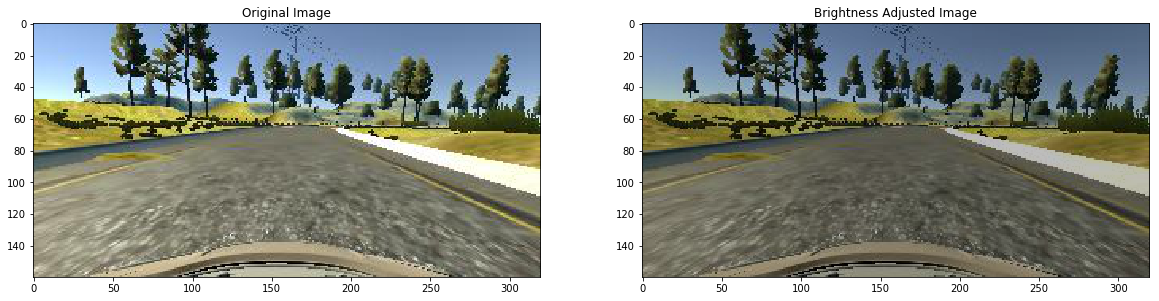

In [12]:
ii = 1
center_image_file = df_log['center'][example_images_idx[ii]]
center_image = plt.imread(path+center_image_file)
center_image_mod = cv2.cvtColor(center_image,cv2.COLOR_RGB2HSV)
random_bright = .25+np.random.uniform()
center_image_mod[:,:,2] = center_image_mod[:,:,2]*random_bright
center_image_mod = cv2.cvtColor(center_image_mod,cv2.COLOR_HSV2RGB)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(center_image)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(center_image_mod)
plt.title("Brightness Adjusted Image")

### Flipping the image horizontally and adding negative of the steering angle to augment data

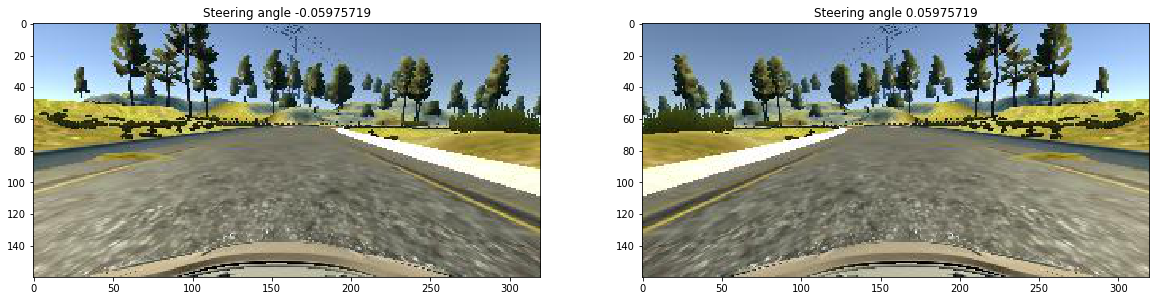

In [14]:
ii = 1
center_image_file = df_log['center'][example_images_idx[ii]]
center_image = plt.imread(path+center_image_file)
center_steering = df_log['steering'][example_images_idx[ii]]
center_image_mod = cv2.flip(center_image,1)
center_steering_mod = center_steering*-1.0

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(center_image)
plt.title("Steering angle {}".format(center_steering))
plt.subplot(1,2,2)
plt.imshow(center_image_mod)
plt.title("Steering angle {}".format(center_steering_mod))

### Adding random shadow as suggested in the blog 
- https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9 

For my earlier submission the vehicle was going off the road after the bridge, where the pavement on the right is missing. The random shadow could had been beneficial, however doesnot look like made much of a difference.

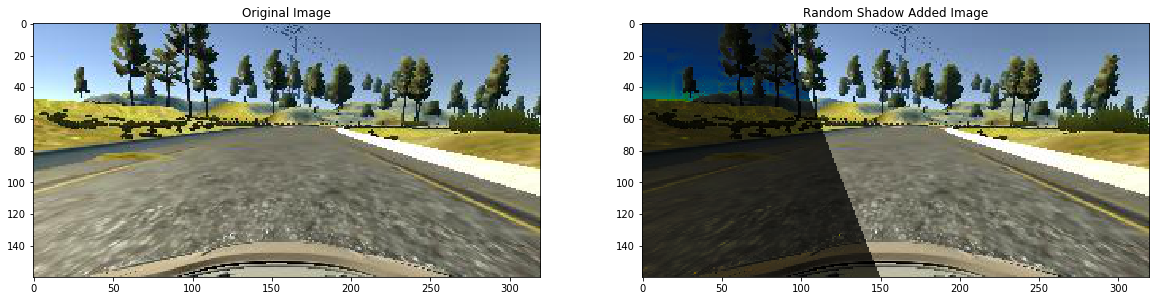

In [23]:
def add_random_shadow(image):
    
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    
    if np.random.randint(2)==1:
        random_bright = .25
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    
    return image

ii = 1
center_image_file = df_log['center'][example_images_idx[ii]]
center_image = plt.imread(path+center_image_file)
center_image_mod = add_random_shadow(center_image)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(center_image)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(center_image_mod)
plt.title("Random Shadow Added Image")